<a href="https://colab.research.google.com/github/VIVEK-JADHAV/TweetSentimentExtraction/blob/master/BaseModelCNN1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS 
import re 
import string
import tensorflow as tf
from tensorflow.keras.layers import Dense,Input,Activation,Flatten,Embedding,GlobalAveragePooling1D,Dropout,LSTM,Conv1D
from tensorflow.keras.models import Model


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Creating a folder to store train and test data
import os
os.mkdir('/content/data')
%cd /content/data/
!pwd

/content/data
/content/data


In [ ]:
!kaggle competitions download -c tweet-sentiment-extraction

  0% 0.00/1.23M [00:00<?, ?B/s]
100% 1.23M/1.23M [00:00<00:00, 41.6MB/s]
  0% 0.00/41.4k [00:00<?, ?B/s]
100% 41.4k/41.4k [00:00<00:00, 43.6MB/s]
  0% 0.00/307k [00:00<?, ?B/s]
100% 307k/307k [00:00<00:00, 101MB/s]


In [ ]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [ ]:
#Loading the train dataset

train=pd.read_csv('/content/data/train.csv')
print('Shape of the train data is ',train.shape)
train.head()

Shape of the train data is  (27481, 4)


,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


* Train dataset has 27481 datapoints and 4 features.

In [ ]:
#Loading the test dataset

test=pd.read_csv('/content/data/test.csv')
print('Shape of the test data is ',test.shape)
test.head()

Shape of the test data is  (3534, 3)


,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


* Test dataset has 3534 datapoints and 3 features.

In [ ]:
#Information regarding train data
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


* text and selected_text columns have one null value and hence, dropping that data point.

In [ ]:
#Dropping the row with null value
train.dropna(inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


In [ ]:
#Information regarding test data
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


* Test dataset has no rows with null values.

### Data Cleaning

In [ ]:
#Reference https://www.kaggle.com/parulpandey/eda-and-preprocessing-for-bert

def clean(tweet):
  #Covert to lowercase
  tweet=tweet.lower()

  #Remove html tags
  tweet=re.sub('<.*?>','',tweet)

  #Remove text in square brackets
  tweet=re.sub('\[.*?\]','',tweet)

  #Remove hyperlinks
  tweet=re.sub('https?://\S+|www\.\S+','',tweet)

  
  return tweet

In [ ]:
#Cleaning the text attribute
train['clean_text']=train['text'].apply(clean)
train['clean_selected_text']=train['selected_text'].apply(str.lower)
train.head()

,textID,text,selected_text,sentiment,clean_text,clean_selected_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,"i`d have responded, if i were going","i`d have responded, if i were going"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo sad i will miss you here in san diego!!!,sooo sad
2,088c60f138,my boss is bullying me...,bullying me,negative,my boss is bullying me...,bullying me
3,9642c003ef,what interview! leave me alone,leave me alone,negative,what interview! leave me alone,leave me alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,"sons of ****, why couldn`t they put them on t...","sons of ****,"


##DATA PREPROCESSING

In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_val,Y_train,Y_val=train_test_split(train[['sentiment','clean_text','textID']],train['clean_selected_text'],
                                               test_size=0.2,random_state=42,stratify=train['sentiment'])

X_train,X_test,Y_train,Y_test=train_test_split(X_train,Y_train,
                                               test_size=0.2,random_state=42,stratify=X_train['sentiment'])

X_train.reset_index(inplace=True,drop=True)
X_val.reset_index(inplace=True,drop=True)
X_test.reset_index(inplace=True,drop=True)

Y_train=Y_train.reset_index(drop=True)
Y_val=Y_val.reset_index(drop=True)
Y_test=Y_test.reset_index(drop=True)

print('X_train shape',X_train.shape,' Y_train shape ',Y_train.shape)
print('X_val shape',X_val.shape,' Y_val shape ',Y_val.shape)
print('X_test shape',X_test.shape,' Y_test shape ',Y_test.shape)

X_train shape (17587, 3)  Y_train shape  (17587,)
X_val shape (5496, 3)  Y_val shape  (5496,)
X_test shape (4397, 3)  Y_test shape  (4397,)


In [ ]:
#Finding highest number of words in the clean_text
count_length=[]
for i in X_train.text.values:
  count_length.append(len(i.split(" ")))
max_count=max(count_length)
print('The highest number of words in essay is ',max_count)

The highest number of words in essay is  101


In [ ]:
#Finding the word length of each clean_text
text_word_len=X_train.text.apply(lambda x: len(x.split(" ")))

text_word_len.describe()

count    21984.000000
mean        13.792303
std          7.185375
min          1.000000
25%          8.000000
50%         13.000000
75%         19.000000
max        101.000000
Name: text, dtype: float64

In [ ]:
#Printing percentile values of word length to get the appropriate sequence length value
for i in range(90,100):
  print('{}th percentile: {}'.format(i,np.percentile(text_word_len.values,i)))

90th percentile: 24.0
91th percentile: 25.0
92th percentile: 25.0
93th percentile: 25.0
94th percentile: 26.0
95th percentile: 26.0
96th percentile: 27.0
97th percentile: 27.0
98th percentile: 28.0
99th percentile: 29.0


In [ ]:
for i in range(990,1000):
  print('{}th percentile: {}'.format(i/10,np.percentile(text_word_len.values,i/10)))

99.0th percentile: 29.0
99.1th percentile: 29.0
99.2th percentile: 30.0
99.3th percentile: 30.0
99.4th percentile: 30.0
99.5th percentile: 30.0
99.6th percentile: 31.0
99.7th percentile: 31.0
99.8th percentile: 31.0
99.9th percentile: 32.0


* 99.9 percentile of clean_text have length less than 32. Hence, fixing the sequence length to 32 for clean_text 

In [ ]:
#Seq_length is 1 more because of sentiment
seq_length=33

In [ ]:
#Tokenizing the clean_text and sentiment and mapping each word to a integer followed by padding to have equal lengths

tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='UNK',filters='')
tokenizer.fit_on_texts(X_train['clean_text'].values+' '+X_train['sentiment'].values)

X_train_clean_text = tokenizer.texts_to_sequences(X_train['sentiment'].values+' '+X_train['clean_text'].values)
X_val_clean_text = tokenizer.texts_to_sequences(X_val['sentiment'].values+' '+X_val['clean_text'].values)
X_test_clean_text = tokenizer.texts_to_sequences(X_test['sentiment'].values+' '+X_test['clean_text'].values)

X_train_tokens = tf.keras.preprocessing.sequence.pad_sequences(X_train_clean_text,maxlen=seq_length,padding='post')
X_val_tokens = tf.keras.preprocessing.sequence.pad_sequences(X_val_clean_text,maxlen=seq_length,padding='post')
X_test_tokens = tf.keras.preprocessing.sequence.pad_sequences(X_test_clean_text,maxlen=seq_length,padding='post')

print('The shape of X_train_tokens ',X_train_tokens.shape)
print('The shape of X_val_tokens ',X_val_tokens.shape)
print('The shape of X_test_tokens ',X_test_tokens.shape)

The shape of X_train_tokens  (17587, 33)
The shape of X_val_tokens  (5496, 33)
The shape of X_test_tokens  (4397, 33)


In [ ]:
sentiment_dict={'positive':6,'negative':7,'neutral':3}

In [ ]:
#Reference https://stackoverflow.com/questions/50060241/how-to-use-glove-word-embeddings-file-on-google-colaboratory

!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip

--2020-08-13 14:08:09--  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.twitter.27B.zip [following]
--2020-08-13 14:08:09--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2020-08-13 14:08:09--  http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [appli

In [ ]:
!unzip /content/data/glove.twitter.27B.zip

Archive:  /content/data/glove.twitter.27B.zip
  inflating: glove.twitter.27B.25d.txt  
  inflating: glove.twitter.27B.50d.txt  
  inflating: glove.twitter.27B.100d.txt  
  inflating: glove.twitter.27B.200d.txt  


In [ ]:
#Loading all the vectors as dictonary with key as string and value as vector

embeddings_index = {}
f = open('/content/data/glove.twitter.27B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.


In [ ]:
vocab_size=len(tokenizer.word_index)+1
print(vocab_size)

32146


In [ ]:
#Getting the weights from the above dictionary for all the words in the document

embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:    
    embedding_matrix[i] = embedding_vector

In [ ]:
#Shape of embedding matrix
embedding_matrix.shape

(32146, 100)

In [ ]:
#Creating start_index and end_index arrays

def get_start_end_index(X_data,Y_data):
    start_index=np.zeros((X_data.shape[0],32),dtype='int32')
    end_index=np.zeros((X_data.shape[0],32),dtype='int32')

    for k in range(X_data.shape[0]):
      tx1=" ".join(X_data['clean_text'][k].split())
      tx2=" ".join(Y_data[k].split())
      #Finding the index position in tx1 where tx2 begins
      idx=tx1.find(tx2)

      #Inserting 1 for each character in tx1 for words present in tx2
      chars=np.zeros(len(tx1))
      chars[idx:idx+len(tx2)]=1

      #Create offsets with(start,end) for each word
      offsets=[]
      j=0
      for i in tx1.split():
        offsets.append((j,j+len(i)+1))
        j+=len(i)+1

      #Find the word index of tx1 using offsets that is present in tx2
      vals=[]
      for i,(o1,o2) in enumerate(offsets):
        if(sum(chars[o1:o2])>0):
          vals.append(i)

      #Insert 1 for the begining word in start_index and for ending word in end_index
      if(len(vals)>0 and len(vals)<=32):
        start_index[k,vals[0]]=1
        end_index[k,vals[-1]]=1
      else:
        start_index[k,0]=1
        end_index[k,-1]=1


    return start_index,end_index 

  


In [ ]:
#Preparing for Y train and test data
Y_tr_1,Y_tr_2=get_start_end_index(X_train,Y_train)
Y_val_1,Y_val_2=get_start_end_index(X_val,Y_val)
Y_te_1,Y_te_2=get_start_end_index(X_test,Y_test)

In [ ]:
#Example for a tweet with values for Y_train,X_train_tokens,start_index,end_index
X_train['clean_text'][129]

' i could act in most buffy eps  i have seen them so many times, but s1 was shaky (apart from eps 1,2,6,7 & 12)'

In [ ]:
Y_train[129]

'i could act in most buffy eps  i have seen them so many times, but s1 was shaky (apart from eps 1,2,6,7 & 12)'

In [ ]:
X_train_tokens[129]

array([   3,    2,  121, 2410,   14,  315, 9774, 4516,    2,   18,  392,
        148,   19,  311, 3087,   21, 9775,   29, 6088, 9776,   49, 4516,
       9777,   81, 9778,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [ ]:
Y_tr_1[129]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [ ]:
Y_tr_2[129]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [ ]:
#Model1: Conv1d

input_layer=Input((seq_length,),name='input')
embedding_layer=Embedding(vocab_size,100,weights=[embedding_matrix],input_length=seq_length,trainable=False)(input_layer)

conv1d=Conv1D(6,2,kernel_initializer=tf.keras.initializers.glorot_uniform(seed=20),name='conv1d')(embedding_layer)
dropout=Dropout(0.2,name="drop_out")(conv1d)
flatten=Flatten(name='flatten')(dropout)

output1=Dense(32,activation='softmax',kernel_initializer=tf.keras.initializers.glorot_uniform(seed=45),name='output1')(flatten)

output2=Dense(32,activation='softmax',kernel_initializer=tf.keras.initializers.glorot_uniform(seed=45),name='output2')(flatten)

model1=Model(inputs=[input_layer],outputs=[output1,output2])

model1.summary()


Model: "functional_47"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 33)]         0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 33, 100)      3214600     input[0][0]                      
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 32, 6)        1206        embedding_24[0][0]               
__________________________________________________________________________________________________
drop_out (Dropout)              (None, 32, 6)        0           conv1d[0][0]                     
______________________________________________________________________________________

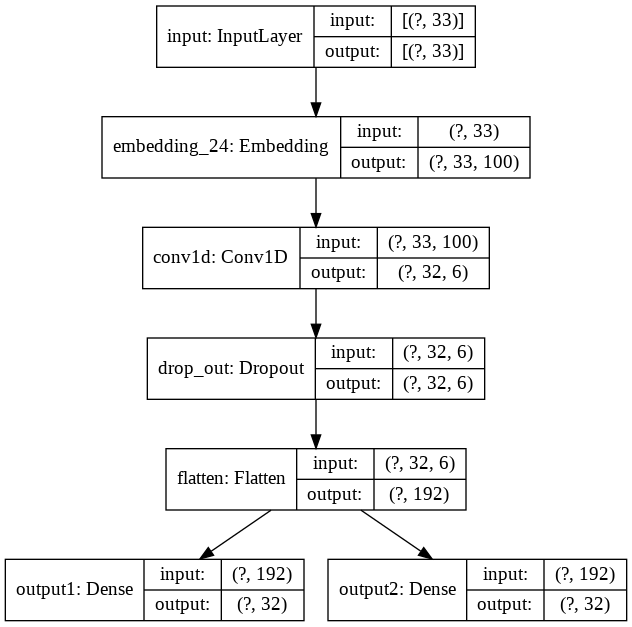

In [ ]:
tf.keras.utils.plot_model(model1, 'Model1.png',show_shapes=True)

 MODEL ARCHIETECTURE 
* This base line model has:
1. Input layer with size:(batch_size,sequence_length)
2.Embedding layer with pre-trained word vectors of 100 dimension.
3. Conv1d: 6 conv1d layers with kernel size 2 and stride=1
4. Dropout: To prevent overfitting
5. Output layer: Two 32 neuron dense layer with softmax activation function.

In [ ]:
#Creating  directory for model and weights 
import os
import shutil

shutil.rmtree('/content/Model1')
shutil.rmtree('/content/model_save1')

os.mkdir('/content/Model1')
os.mkdir('/content/model_save1')

In [ ]:
#Setting the parameters for TensorBoard
from tensorflow.keras.callbacks import TensorBoard
%load_ext tensorboard
!rm -rf ./logs/ 

log_dir='/content/Model1'
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Save  model at every epoch
from tensorflow.keras.callbacks import ModelCheckpoint

filepath="/content/model_save1/weights-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [ ]:
#Compiling the model
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy())

In [ ]:
#Fitting the model and running it for 25 epochs
callback=[tensorboard_callback,checkpoint]
model1.fit(X_train_tokens,[Y_tr_1,Y_tr_2],batch_size=32,epochs=20,callbacks=callback,
           validation_data=(X_val_tokens,[Y_val_1,Y_val_2]))

Epoch 1/20
549/550 [============================>.] - ETA: 0s - loss: 4.7127 - output1_loss: 1.9145 - output2_loss: 2.7983
Epoch 00001: val_loss improved from inf to 3.82617, saving model to /content/model_save1/weights-01-3.8262.hdf5
550/550 [==============================] - 5s 8ms/step - loss: 4.7120 - output1_loss: 1.9140 - output2_loss: 2.7980 - val_loss: 3.8262 - val_output1_loss: 1.5618 - val_output2_loss: 2.2643
Epoch 2/20
544/550 [============================>.] - ETA: 0s - loss: 3.6565 - output1_loss: 1.5331 - output2_loss: 2.1234
Epoch 00002: val_loss improved from 3.82617 to 3.42054, saving model to /content/model_save1/weights-02-3.4205.hdf5
550/550 [==============================] - 4s 8ms/step - loss: 3.6555 - output1_loss: 1.5331 - output2_loss: 2.1223 - val_loss: 3.4205 - val_output1_loss: 1.4407 - val_output2_loss: 1.9798
Epoch 3/20
549/550 [============================>.] - ETA: 0s - loss: 3.3898 - output1_loss: 1.4313 - output2_loss: 1.9585
Epoch 00003: val_loss imp

In [ ]:
%tensorboard --logdir '/content/Model1'

* There are two loss values: One for start_index and other for end_index

* After trying with different combination of number of conv1D filters and kernals, lowest loss was obtained for filter=6 and kernal=2 with Adam Optimizer with learning rate=0.001.

* The overall loss reduces gradually but after epoch 7, the train and validation loss starts to diverge, indicating overfit. 

* The lowest overall loss is 3.1723


In [ ]:
#Loading the best weights
model1.load_weights('/content/model_save1/weights-12-3.1723.hdf5')

In [ ]:
def jaccard(str1, str2):
  '''Returns jaccard score between str1 and str2 ''' 
  a = set(str1.lower().split()) 
  b = set(str2.lower().split())
  c = a.intersection(b)
  return float(len(c)) / (len(a) + len(b) - len(c))

In [ ]:
#Getting start and end index for hold out test dataset
st_idx,end_idx=model1.predict(X_test_tokens,batch_size=32,verbose=1)

138/138 [==============================] - 0s 3ms/step


In [ ]:
def compute_jaccard(st_idx,end_idx,X,Y):
  '''Computes mean jaccard score of all tweets '''
  all_jaccard=[]
  df=pd.DataFrame(columns=['clean_text','selected_text','predicted','jaccard','sentiment'])
  for i in range(len(st_idx)):
    initial=np.argmax(st_idx[i])
    final=np.argmax(end_idx[i])
    sent2=" ".join(X['clean_text'][i].split()[initial:final+1])
    sent1=Y[i] 
    df.loc[i,'clean_text']=X['clean_text'][i]   
    df.loc[i,'selected_text']=sent1
    df.loc[i,'predicted']=sent2
    df.loc[i,'sentiment']=X['sentiment'][i]
    jaccard_score=jaccard(sent1,sent2)
    df.loc[i,'jaccard']=jaccard_score
    all_jaccard.append(jaccard_score)
  return np.mean(np.array(all_jaccard)),df



In [ ]:
#Mean jaccard score of hold out test dataset
score,df=compute_jaccard(st_idx,end_idx,X_test,Y_test)
print(score)

0.5877780070041771


#### Error Analysis

In [ ]:
#Average Jaccard score for each sentiment

pos_average=np.mean(X_test['jaccard'][X_test['sentiment']=='positive'])
print('The average jaccard score for postive sentiment is  ',pos_average)

neg_average=np.mean(X_test['jaccard'][X_test['sentiment']=='negative'])
print('The average jaccard score for negative sentiment is  ',neg_average)

neu_average=np.mean(X_test['jaccard'][X_test['sentiment']=='neutral'])
print('The average jaccard score for neutral sentiment is  ',neu_average)

The average jaccard score for postive sentiment is   0.3588792506400489
The average jaccard score for negative sentiment is   0.36414772804244877
The average jaccard score for neutral sentiment is   0.9220793961009783


In [ ]:
#Adding len of the selected text column

X_test['len_selected_text']=X_test['selected_text'].apply(lambda x: len(x.split()))
X_test['len_text']=X_test['text'].apply(lambda x: len(x.split()))
X_test['diff_len']=abs(X_test['len_selected_text']-X_test['len_text'])
X_test.head()

,sentiment,clean_text,textID,jaccard,predicted_text,selected_text,len_selected_text,text,len_text,diff_len
0,negative,misses driving already,197aa929a2,1,misses driving already,misses driving already,3,misses driving already,3,0
1,positive,name the rest? let`s see. mystery jets are pr...,7648a76c96,0.0833333,pretty cool. ida maria and you shud rly listen...,cool.,1,name the rest? let`s see. mystery jets are pr...,20,19
2,neutral,anyways have a severe headache ryt now! i jst...,14fc34a4fb,0.909091,anyways have a severe headache ryt now! i jst ...,anyways have a severe headache ryt now! i jst ...,24,anyways have a severe headache ryt now! i jst...,24,0
3,neutral,25-man ulduar is hard...,50662e359b,1,25-man ulduar is hard...,25-man ulduar is hard...,4,25-man ulduar is hard...,4,0
4,negative,cried like a fukn baby today durin da senior s...,b66219e011,0.0769231,cried like a fukn baby today durin da senior s...,miss,1,cried like a fukn baby today durin da senior s...,15,14


In [ ]:
#Total number of tweets with correct prediction and incorrect prediction
pos_jac_1=X_test[X_test['jaccard']==1]
pos_jac_0=X_test[X_test['jaccard']!=1]

In [ ]:
print('The total number of  tweets is',X_test.shape[0])
print('The total number of  tweets with jaccard=1 is',pos_jac_1.shape[0])
print('The total number of  tweets with jaccard not 1 is',pos_jac_0.shape[0])

The total number of  tweets is 4397
The total number of  tweets with jaccard=1 is 1558
The total number of  tweets with jaccard not 1 is 2839


In [ ]:
#Performance of model when both tweet and selected text is same

total_zero_diff=X_test[X_test['diff_len']==0].shape[0]
zero_diff_jaccard_1=pos_jac_1[pos_jac_1['diff_len']==0].shape[0]
result=zero_diff_jaccard_1*100/total_zero_diff
print('The percentage of  tweets with jaccard=1 when both tweet and selected text were same is',result)

The percentage of  tweets with jaccard=1 when both tweet and selected text were same is 64.51612903225806


In [ ]:
#Performance of model when difference between  tweet and selected text is less than 10

diff_less_10=X_test[X_test['diff_len']<=10].shape[0]
diff_less_10_jaccard_1=pos_jac_1[pos_jac_1['diff_len']<=10].shape[0]
result=diff_less_10_jaccard_1*100/diff_less_10
print('The percentage of tweets with jaccard=1 when length difference is less than 10 is',result)

The percentage of tweets with jaccard=1 when length difference is less than 10 is 44.80341359341664


In [ ]:
#Performance of model when difference between  tweet and selected text is greter than 10 but less than 20

diff_less_20=X_test[(X_test['diff_len']>10) & (X_test['diff_len']<=20)].shape[0]
diff_less_20_jaccard_1=pos_jac_1[(pos_jac_1['diff_len']>10) & (pos_jac_1['diff_len']<=20)].shape[0]
result=diff_less_20_jaccard_1*100/diff_less_20
print('The percentage of tweets with jaccard=1 when length difference is greter than 10 and less than 20 is',result)

The percentage of tweets with jaccard=1 when length difference is greter than 10 and less than 20 is 8.607021517553793


In [ ]:
#Performance of model when difference between  tweet and selected text is greter than 20

diff_less_30=X_test[(X_test['diff_len']>20)].shape[0]
diff_less_30_jaccard_1=pos_jac_1[(pos_jac_1['diff_len']>20)].shape[0]
result=diff_less_30_jaccard_1*100/diff_less_30
print('The percentage of positive tweets with jaccard=1 when length difference is greter than 20 is',result)

The percentage of positive tweets with jaccard=1 when length difference is greter than 20 is 5.150214592274678


In [ ]:
print(np.mean(X_test['jaccard']))

0.5882384303400673


Conclusion
* The CNN1D model performs resonablly well when the text and selected text are of same length.
* It does resonablly well when the difference between tweet selected text is of only few words but does not perform well when the difference increases.

In [ ]:
#Passing the test data to above function and get the submission data frame
test_data=test.copy()
submission=final_test(test_data,tokenizer,model1)

111/111 [==============================] - 0s 3ms/step


In [ ]:
def final_test(test,tokenizer,model):
  '''Pre-process test data and predict selected_text'''
  id=test['textID']
  #Tokenize the test data
  test['clean_text']=test['text'].apply(clean)
  X_data=tokenizer.texts_to_sequences(test['sentiment'].values+' '+test['clean_text'].values)
  X_tokens=tf.keras.preprocessing.sequence.pad_sequences(X_data,maxlen=33,padding='post')

  #Predicte the start and end index
  st_idx,end_idx=model.predict(X_tokens,batch_size=32,verbose=1)

  #Find the words between start and end index
  selected_list=[]
  for i in range(len(st_idx)):
    initial=np.argmax(st_idx[i])
    final=np.argmax(end_idx[i])
    selected_text=" ".join(test['clean_text'][i].split()[initial:final+1])
    selected_list.append(selected_text)

  #Create a dataframe for submission to Kaggle
  submission=pd.DataFrame(columns=['textID','selected_text'])
  submission['textID']=id
  submission['selected_text']=selected_list
  return submission


In [ ]:
#Create submission.csv file
submission.to_csv('/content/submission.csv',index=False)

Kaggle Score
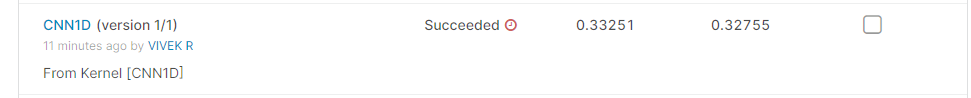

In [ ]:
def final_test(test,tokenizer,model):
  '''Pre-process test data and predict selected_text'''
  id=test['textID']
  #Tokenize the test data
  test['clean_text']=test['text'].apply(clean)
  X_data=tokenizer.texts_to_sequences(test['sentiment'].values+' '+test['clean_text'].values)
  X_tokens=tf.keras.preprocessing.sequence.pad_sequences(X_data,maxlen=33,padding='post')

  #Predicte the start and end index
  st_idx,end_idx=model.predict(X_tokens,batch_size=32,verbose=1)

  #Find the words between start and end index
  selected_list=[]
  for i in range(len(st_idx)):
    initial=np.argmax(st_idx[i])
    final=np.argmax(end_idx[i])
    selected_text=" ".join(test['clean_text'][i].split()[initial:final+1])
    selected_list.append(selected_text)

  #Create a dataframe for submission to Kaggle
  submission=pd.DataFrame(columns=['textID','selected_text'])
  submission['textID']=id
  submission['selected_text']=selected_list
  return submission


In [ ]:
#Passing the test data to above function and get the submission data frame
test_data=test.copy()
submission=final_test(test_data,tokenizer,model1)

111/111 [==============================] - 0s 3ms/step


In [ ]:
#Create submission.csv file
submission.to_csv('/content/submission.csv',index=False)

Kaggle Score is 0.33
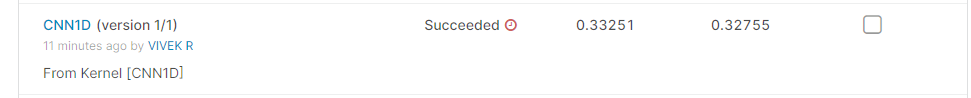